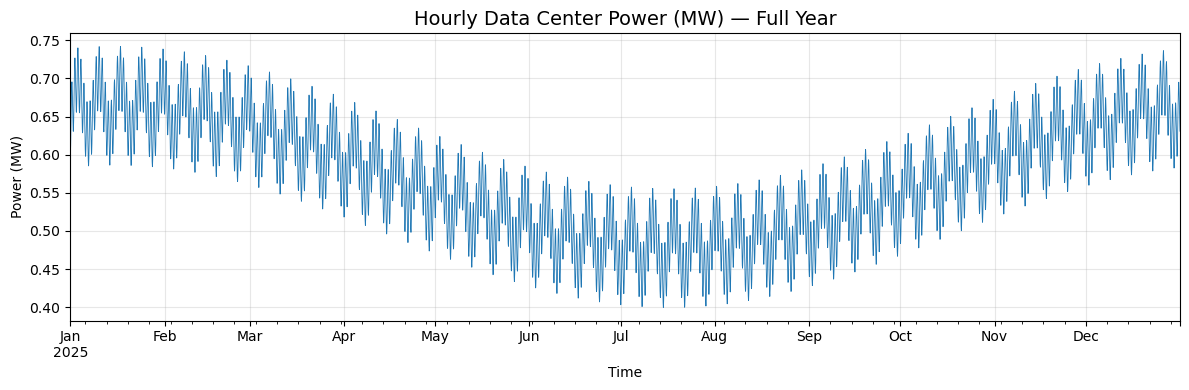

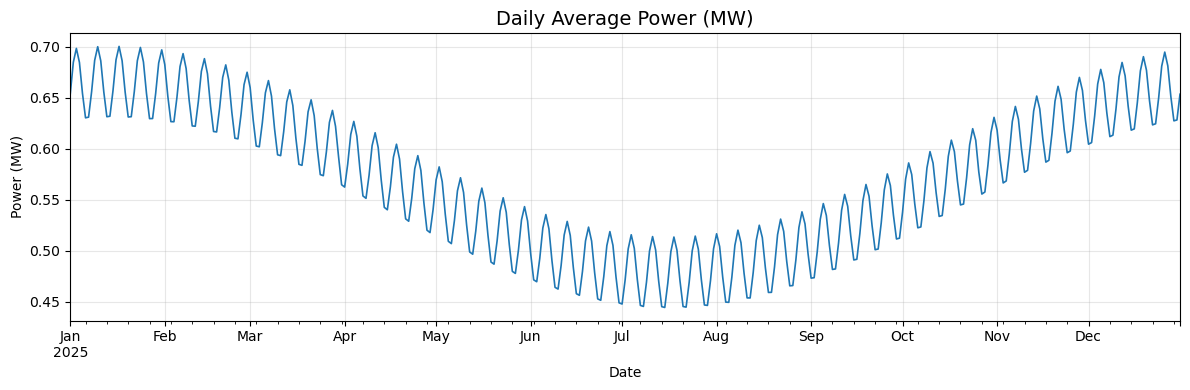

Data saved to datacenter_hourly_power.csv


In [2]:
# -*- coding: utf-8 -*-
# Simulate or reconstruct hourly data center power using Fourier components.
# - "Reconstruct" mode: strict time-domain reconstruction from (f, A, phi)
# - "Simulate" mode: use Fourier shape as a driver with variability + mean + clipping

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import List, Optional, Iterable, Dict, Any, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# Fourier term definition
# ------------------------------------------------------------
@dataclass
class FourierTerm:
    """
    A single Fourier component using the cosine convention:
        term(t) = amplitude * cos(2π * f_cpd * t_days + phase_rad)

    Notes
    -----
    - frequency_cycles_per_day is in cycles/day
    - phase_rad should match the phase exported by your FFT (cosine basis).
    """
    frequency_cycles_per_day: float
    amplitude: float
    phase_rad: float = 0.0

    @staticmethod
    def from_dict(d: Dict[str, Any]) -> "FourierTerm":
        return FourierTerm(
            frequency_cycles_per_day=float(d["frequency_cycles_per_day"]),
            amplitude=float(d.get("amplitude", 0.0)),
            phase_rad=float(d.get("phase_rad", 0.0)),
        )


# ------------------------------------------------------------
# Helper functions
# ------------------------------------------------------------
def _build_time_axis(start: str = "2025-01-01", hours: int = 8760, tz: Optional[str] = None) -> pd.DatetimeIndex:
    """Create a DatetimeIndex with hourly steps."""
    if hours < 1:
        raise ValueError("hours must be >= 1")
    return pd.date_range(start=start, periods=hours, freq="H", tz=tz)


def _parse_terms(fourier_terms: Union[List[Dict[str, Any]], List[FourierTerm]]) -> List[FourierTerm]:
    """Accepts list[dict] or list[FourierTerm] and returns list[FourierTerm]."""
    if not fourier_terms:
        return []
    if isinstance(fourier_terms[0], dict):  # type: ignore[index]
        return [FourierTerm.from_dict(d) for d in fourier_terms]  # type: ignore[arg-type]
    return list(fourier_terms)  # type: ignore[return-value]


def _t_days_from_index(idx: pd.DatetimeIndex) -> np.ndarray:
    """
    Convert DatetimeIndex to time in days relative to idx[0].
    Uses nanoseconds integer representation to avoid tz pitfalls.
    """
    # idx.asi8 is int64 nanoseconds since epoch
    t0_ns = int(idx[0].value)
    t_ns = idx.asi8.astype(np.int64) - t0_ns
    # ns -> s -> h -> d
    t_days = (t_ns / 1e9) / 3600.0 / 24.0
    return t_days


# ------------------------------------------------------------
# Core generators
# ------------------------------------------------------------
def _fourier_sum_cos(idx: pd.DatetimeIndex, terms: Iterable[FourierTerm]) -> np.ndarray:
    """
    Strict cosine-basis sum with NO normalization/scaling.
    Returns the raw signal (not demeaned unless you choose to).
    """
    n = len(idx)
    if n == 0:
        return np.array([], dtype=float)

    t_days = _t_days_from_index(idx)
    y = np.zeros(n, dtype=float)
    for term in terms:
        w = 2.0 * math.pi * term.frequency_cycles_per_day
        y += term.amplitude * np.cos(w * t_days + term.phase_rad)
    return y


# ------------------------------------------------------------
# Public APIs
# ------------------------------------------------------------
def reconstruct_from_fourier(
    *,
    fourier_terms: List[Dict[str, Any]] | List[FourierTerm],
    start: str,
    hours: int,
    tz: Optional[str] = None,
    dc: float = 0.0,
    demean: bool = False,
) -> pd.Series:
    """
    Strict time-domain reconstruction from FFT-exported (f, A, phi),
    using cosine convention. No normalization, no variability, no clipping.

    Parameters
    ----------
    fourier_terms : list[dict] | list[FourierTerm]
        Components with keys frequency_cycles_per_day, amplitude, phase_rad.
        Typically exported by your FFT script (DC excluded there).
    start : str
        Start datetime string compatible with pandas date_range.
    hours : int
        Number of hourly samples.
    tz : str, optional
        Timezone string (e.g., "Europe/Berlin").
    dc : float
        Optional DC offset to add (if you want mean back). If your FFT
        pipeline excluded DC, set dc to the original mean if needed.
    demean : bool
        If True, subtract the mean of the summed components before adding dc.

    Returns
    -------
    pd.Series named "reconstructed": strict reconstruction values.
    """
    idx = _build_time_axis(start=start, hours=hours, tz=tz)
    terms = _parse_terms(fourier_terms)
    y = _fourier_sum_cos(idx, terms) if terms else np.zeros(len(idx), dtype=float)
    if demean and y.size:
        y = y - float(y.mean())
    y = y + dc
    return pd.Series(y, index=idx, name="reconstructed")


def simulate_hourly_power(
    *,
    p_max_mw: float = 1.0,
    full_load_hours: float = 5000.0,
    fourier_terms: List[Dict[str, Any]] | List[FourierTerm] = (),
    start: str = "2025-01-01",
    hours: int = 8760,
    variability: float = 0.30,
    tz: Optional[str] = None,
    keep_mean_exact: bool = True,
) -> pd.DataFrame:
    """
    Simulate hourly power using Fourier shape as a driver.

    This DOES NOT strictly reconstruct original amplitudes. It:
      1) builds a cosine-basis sum from terms,
      2) normalizes by max-abs to [-1, 1] (if non-flat),
      3) scales by `variability` as a relative modulation around target mean,
      4) clips to [0, p_max_mw],
      5) optionally rescales to make the annual mean exactly target_mean.

    Parameters
    ----------
    p_max_mw : float
        Maximum power (MW).
    full_load_hours : float
        Annual full load hours, sets target mean = p_max * FLH / 8760.
    fourier_terms : list[dict] | list[FourierTerm]
        Fourier components (only shape matters in this mode).
    start : str
        Start datetime string.
    hours : int
        Number of hours to simulate.
    variability : float
        Strength of fluctuation (0–1).
    tz : str, optional
        Timezone string.
    keep_mean_exact : bool
        If True, after clipping, globally scale to hit the target mean.

    Returns
    -------
    pd.DataFrame
        index = hourly timestamps; columns = power_mw
    """
    if p_max_mw <= 0:
        raise ValueError("p_max_mw must be > 0")
    if hours < 1:
        raise ValueError("hours must be >= 1")
    if not (0.0 <= variability <= 1.0):
        raise ValueError("variability must be in [0,1]")

    idx = _build_time_axis(start=start, hours=hours, tz=tz)
    target_mean_load_mw = p_max_mw * (full_load_hours / 8760.0)
    terms = _parse_terms(fourier_terms)

    # Generate raw cosine sum (zero-mean NOT enforced here)
    raw = _fourier_sum_cos(idx, terms) if terms else np.zeros(len(idx), dtype=float)

    # Normalize to [-1, 1] for shape-only modulation
    if np.allclose(raw.std(), 0.0):
        norm = np.zeros_like(raw)
    else:
        max_abs = float(np.max(np.abs(raw)))
        norm = raw / max_abs if max_abs > 0 else np.zeros_like(raw)

    # Relative modulation around target mean
    profile = 1.0 + variability * norm
    power = target_mean_load_mw * profile

    # Clip to physical bounds
    power = np.clip(power, 0.0, p_max_mw)

    # Optionally enforce exact annual mean after clipping
    if keep_mean_exact and power.mean() > 0:
        scale = target_mean_load_mw / float(power.mean())
        power = np.clip(power * scale, 0.0, p_max_mw)

    df = pd.DataFrame(index=idx)
    df["power_mw"] = power
    return df


# ------------------------------------------------------------
# Example run
# ------------------------------------------------------------
if __name__ == "__main__":
    # Example Fourier list (replace with your exported JSON terms)
    fourier_list = [
        {
            "frequency_cycles_per_day": 1.0,
            "amplitude": 0.435,
            "phase_rad": 3.08384787,
        },
        {
            "frequency_cycles_per_day": 0.002738475581926061,
            "amplitude": 1,
            "phase_rad": -0.25139,
        },
        {
            "frequency_cycles_per_day": 0.14285714285,
            "amplitude": 0.4,
            "phase_rad": -2.2116281,
        },
    ]

    # --------------------------
    # (A) Strict reconstruction
    # --------------------------
    recon = reconstruct_from_fourier(
        fourier_terms=fourier_list,
        start="2025-01-01",
        hours=8760,
        tz="Europe/Berlin",
        dc=0.0,        # If original mean (DC) is known, set it here
        demean=False,  # Set True if you want to explicitly remove mean of components
    )

 

    # --------------------------
    # (B) Simulation (shape-driven)
    # --------------------------
    df = simulate_hourly_power(
        p_max_mw=1.0,
        full_load_hours=5000,
        fourier_terms=fourier_list,
        start="2025-01-01",
        hours=8760,
        variability=0.30,
        tz="Europe/Berlin",
        keep_mean_exact=True,
    )

    # Plot 1: Hourly power (full year)
    plt.figure(figsize=(12, 4))
    df["power_mw"].plot(linewidth=0.6)
    plt.title("Hourly Data Center Power (MW) — Full Year", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Daily average power
    daily = df["power_mw"].resample("D").mean()
    plt.figure(figsize=(12, 4))
    daily.plot(linewidth=1.2)
    plt.title("Daily Average Power (MW)", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Power (MW)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save simulated series
    out_csv = "datacenter_hourly_power.csv"
    df.to_csv(out_csv)
    print(f"Data saved to {out_csv}")
